In [1]:
# !git clone --recursive https://github.com/coreylammie/MemTorch
# %cd MemTorch
# !pip install .

In [1]:
import torch
from torch.autograd import Variable
import memtorch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from memtorch.utils import LoadMNIST
import numpy as np
import matplotlib.pyplot as plt
import torchvision


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def test(model, test_loader):
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):        
        output = model(data.to(device))
        pred = output.data.max(1)[1]
        correct += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()

    return 100. * float(correct) / float(len(test_loader.dataset))

In [7]:
device = torch.device('cpu' if 'cpu' in memtorch.__version__ else 'cuda')
epochs = 1
learning_rate = 1e-1
step_lr = 5
batch_size = 256
train_loader, validation_loader, test_loader = LoadMNIST(batch_size=batch_size, validation=False)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_accuracy = 0

for epoch in range(0, epochs):
    print('Epoch: [%d]\t\t' % (epoch + 1), end='')
    if epoch % step_lr == 0:
        learning_rate = learning_rate * 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()

    accuracy = test(model, test_loader)
    print('%2.2f%%' % accuracy)
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), 'trained_model.pt')
        best_accuracy = accuracy

Epoch: [1]		92.46%


In [8]:
def find_nearest_value(weights, stable_weights):
    nearest_values = np.zeros_like(weights)
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            min_diff = np.inf
            for k in range(stable_weights.shape[0]):
                diff = abs(weights[i, j] - stable_weights[k])
                if diff < min_diff:
                    min_diff = diff
                    nearest_val = stable_weights[k]
            nearest_values[i, j] = nearest_val
    return nearest_values

n_states: 16
Accuracy: 92.15%
n_states: 14
Accuracy: 92.49%
n_states: 12
Accuracy: 92.26%
n_states: 10
Accuracy: 92.55%
n_states: 8
Accuracy: 89.71%
n_states: 6
Accuracy: 85.49%
n_states: 4
Accuracy: 55.65%
n_states: 2
Accuracy: 33.98%


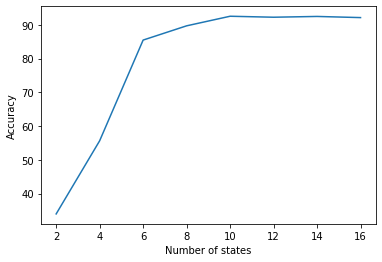

In [9]:
fc1_weights = model.fc1.weight.data.cpu().numpy()
fc2_weights = model.fc2.weight.data.cpu().numpy()

w_min_fc1, w_max_fc1 = fc1_weights.min(), fc1_weights.max()
w_min_fc2, w_max_fc2 = fc2_weights.min(), fc2_weights.max()

n_states = np.arange(2, 18, 2)
n_states = n_states[::-1]

accuracies = []
for n in n_states:
    print('n_states: %d' % n)
    fc1_stable_weights = np.linspace(w_min_fc1, w_max_fc1, n)
    fc2_stable_weights = np.linspace(w_min_fc2, w_max_fc2, n)
    fc1_nearest_values = find_nearest_value(fc1_weights, fc1_stable_weights)
    fc2_nearest_values = find_nearest_value(fc2_weights, fc2_stable_weights)

    model.fc1.weight.data = torch.Tensor(fc1_nearest_values).to(device)
    model.fc2.weight.data = torch.Tensor(fc2_nearest_values).to(device)

    accuracy = test(model, test_loader)
    accuracies.append(accuracy)
    print('Accuracy: %2.2f%%' % accuracy)

plt.plot(n_states, accuracies)
plt.xlabel('Number of states')
plt.ylabel('Accuracy')
plt.savefig('accuracy_vs_n_states.png')